<a href="https://colab.research.google.com/github/ariel-hedvat/AdvancedMLDLCourseAssignments/blob/main/Experiments/Spotify_Music_Recommendation_with_LightGCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spotify Music Recommendation with LightGCN

By Ben Alexander, Jean-Peic Chou, Aman Bansal

This is the Colab notebook associated with our Medium post! (We will update this with the link once the article is published)

Note: please ensure that you have GPU runtime enabled! Go to Runtime -> Change runtime type. Then set the Hardware accelerator to GPU if it isn't already set.

This Colab will:
1. Teach you how to use PyTorch Geometric to write and train your own GNNs from scratch, by showing how to implement LightGCN for music recommendation
2. Evaluate the performance by recommending songs for a bunch of playlists from the Spotify Million Playlist Dataset
3. Produce some animations and visualizations of the learned playlist/node embeddings. Stick around until the end to see some interesting discoveries about country music playlists, Drake songs, and Taylor Swift songs!

## Install and import necessary packages

First, we need to install a newer version of matplotlib for our visualizations later on.

PLEASE FOLLOW THE MESSAGE THAT POPS UP AND RESTART THE RUNTIME AFTER RUNNING THIS CELL!

In [1]:
!pip install matplotlib==3.5.0

Again, please restart the runtime after running the cell above!! Click the button that comes up.

Here are some more installations:

In [2]:
!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu111.html

!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu111.html

# We are installing torch-geometric from a specific GitHub commit instead of from pip wheels/conda. This is because there is currently a bug in
# RandomLinkSplit that has been fixed in the repo, but not yet in an official release. Once release 2.0.3 is available, we can go back
# to installing from pip wheels. See here for more info about the bug: https://github.com/pyg-team/pytorch_geometric/issues/3440
!pip install git+https://github.com/pyg-team/pytorch_geometric.git@7fc1767ece2edd614575dcbff1eb8f79f1035742

Looking in links: https://data.pyg.org/whl/torch-1.10.0+cu111.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torch-scatter: filename=torch_scatter-2.1.2-cp310-cp310-linux_x86_64.whl size=3588748 sha256=b526cf46f809301d369a6ba4d8a3d5203abe3b72d4d42dbe6a98293fe16021ff
  Stored in directory: /root/.cache/pip/wheels/92/f1/2b/3b46d54b134259f58c8363568569053248040859b1a145b3ce
Successfully built torch-scatter
Looking in links: https://data.pyg.org/whl/torch-1.10.0+cu111.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torch-sparse: filename=torch_sparse-0.6.18-cp310-cp310-linux_x86_64.whl size=2731965 sha256=0ceb4924711587fa4b841e6775d6456214afdae1868ea8fc89adf64b9d02396c
  Stored in directory: /root/.cache/pip/wheels/c9/dd/0f/a6a16f9f3b0236733d257b4b4ea91b548b984a341ed3b8f38c
Successfully built

Import necessary packages:

In [3]:
import json
import numpy as np
import os
import torch
from torch_geometric import seed_everything
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import MessagePassing
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.utils import degree

import matplotlib.pyplot as plt
from matplotlib import animation, rc
from sklearn.decomposition import PCA
from IPython.display import HTML

seed_everything(5) # set random seed

In [4]:
import matplotlib
matplotlib.__version__
assert matplotlib.__version__ == '3.5.0' # if this fails, makes sure you ran the matplotlib installation above AND restarted your runtime

## Load data + data pre-processing

The full Spotify Million Playlist Dataset is available at https://www.aicrowd.com/challenges/spotify-million-playlist-dataset-challenge.

We have already gone ahead and pre-processed the data, rather than importing the entire dataset here, for two reasons:
1. You need to make an account to download the Spotify dataset, so we don't think we should post it online
2. The full dataset is around 33GB, which is very large!

Of course, feel free to download it yourself and play around with it.

Our pre-processing code is available in our GitHub repo at https://github.com/ba305/LightGCN-Spotify. There is also an explanation of the key parts of the pre-processing code in our Medium article.

For now, we will import the already-preprocessed data, which is hosted at our GitHub repo.

In [5]:
! wget https://raw.githubusercontent.com/ba305/LightGCN-Spotify/main/data/dataset_large/data_object.pt
! wget https://raw.githubusercontent.com/ba305/LightGCN-Spotify/main/data/dataset_large/dataset_stats.json
! wget https://raw.githubusercontent.com/ba305/LightGCN-Spotify/main/data/dataset_large/song_info.json
! wget https://raw.githubusercontent.com/ba305/LightGCN-Spotify/main/data/dataset_large/playlist_info.json

--2024-03-19 12:20:28--  https://raw.githubusercontent.com/ba305/LightGCN-Spotify/main/data/dataset_large/data_object.pt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21104811 (20M) [application/octet-stream]
Saving to: ‘data_object.pt’

data_object.pt      100%[===================>]  20.13M  46.2MB/s    in 0.4s    

2024-03-19 12:20:30 (46.2 MB/s) - ‘data_object.pt’ saved [21104811/21104811]

--2024-03-19 12:20:30--  https://raw.githubusercontent.com/ba305/LightGCN-Spotify/main/data/dataset_large/dataset_stats.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, 

Now that we downloaded our preprocessed dataset, we can load it in.

In [6]:
# Load data
base_dir = "."
data = torch.load(os.path.join(base_dir, "data_object.pt"))
with open(os.path.join(base_dir, "dataset_stats.json"), 'r') as f:
    stats = json.load(f)
num_playlists, num_nodes = stats["num_playlists"], stats["num_nodes"]

### Train/validation/test split

The train/validation/test split is very important! We will use a 70%-15%-15% split.

For graph ML problems, this splitting is quite complex (see our article for more details). Luckily, the RandomLinkSplit function from PyG can help us if we use it correctly.

We need to specify is_undirected=True so that it knows to avoid data leakage from reverse edges (e.g., [4,5] and [5,4] should stay in the same split since they are basically the same edge). We also set add_negative_train_samples=False and neg_sampling_ratio=0 since we have our own negative sampling implementation.

In [7]:
# Train/val/test split
transform = RandomLinkSplit(is_undirected=True, add_negative_train_samples=False, neg_sampling_ratio=0,
                            num_val=0.15, num_test=0.15)
train_split, val_split, test_split = transform(data)
# Confirm that every node appears in every set above
assert train_split.num_nodes == val_split.num_nodes and train_split.num_nodes == test_split.num_nodes

We can now take a quick look at the splits. Note that message passing edges are stored in the .edge_index attribute, and supervision/evaluation edges are stored in the .edge_label_index attribute. Keep in mind that the message passing edges are directed, while the evaluation edges are undirected.

In [8]:
print(train_split)
print(val_split)
print(test_split)

Data(edge_index=[2, 923296], num_nodes=14992, edge_label=[461648], edge_label_index=[2, 461648])
Data(edge_index=[2, 923296], num_nodes=14992, edge_label=[98924], edge_label_index=[2, 98924])
Data(edge_index=[2, 1121144], num_nodes=14992, edge_label=[98924], edge_label_index=[2, 98924])


We will want to load our evaluation edges in batches using a DataLoader. Therefore, we first must create a PyG Dataset object which specifies how to load in each batch. See the documentation for more information: https://pytorch-geometric.readthedocs.io/en/latest/notes/create_dataset.html

In [9]:
class PlainData(Data):
    """
    Custom Data class for use in PyG. Basically the same as the original Data class from PyG, but
    overrides the __inc__ method because otherwise the DataLoader was incrementing indices unnecessarily.
    Now it functions more like the original DataLoader from PyTorch itself.
    See here for more information: https://pytorch-geometric.readthedocs.io/en/latest/notes/batching.html
    """
    def __inc__(self, key, value, *args, **kwargs):
        return 0

class SpotifyDataset(Dataset):
    """
    Dataset object containing the Spotify supervision/evaluation edges. This will be used by the DataLoader to load
    batches of edges to calculate loss or evaluation metrics on. Here, get(idx) will return ALL outgoing edges of the graph
    corresponding to playlist "idx." This is because when calculating metrics such as recall@k, we need all of the
    playlist's positive edges in the same batch.
    """
    def __init__(self, root, edge_index, transform=None, pre_transform=None):
        self.edge_index = edge_index
        self.unique_idxs = torch.unique(edge_index[0,:]).tolist() # playlists will all be in row 0, b/c sorted by RandLinkSplit
        self.num_nodes = len(self.unique_idxs)
        super().__init__(root, transform, pre_transform)

    def len(self):
        return self.num_nodes

    def get(self, idx): # returns all outgoing edges associated with playlist idx
        edge_index = self.edge_index[:, self.edge_index[0,:] == idx]
        return PlainData(edge_index=edge_index)

For each split, we have a set of message passing edges (for GNN propagation/getting final multi-scale node embeddings), and also a set of evaluation edges (used to calculate loss/performance metrics). For message passing edges, we can just store them in a PyG Data object. For evaluation edges, we put them in a SpotifyDataset object so we can load them in in batches with a DataLoader.

In [10]:
train_ev = SpotifyDataset('temp', edge_index=train_split.edge_label_index)
train_mp = Data(edge_index=train_split.edge_index)

val_ev = SpotifyDataset('temp', edge_index=val_split.edge_label_index)
val_mp = Data(edge_index=val_split.edge_index)

test_ev = SpotifyDataset('temp', edge_index=test_split.edge_label_index)
test_mp = Data(edge_index=test_split.edge_index)

# Creating the Model

Now it's time to create the full LightGCN model! Please see the documentation for more details on how to create message passing networks: https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html

We need to create two classes. First is a class that defines how a single LightGCN message passing layer should work. For this, we need to specify the aggregation function (in the constructor), and also define the message() and forward() functions. Please see our article for a more in-depth description of what each function does.

In [11]:
class LightGCN(MessagePassing):
    """
    A single LightGCN layer. Extends the MessagePassing class from PyTorch Geometric
    """
    def __init__(self):
        super(LightGCN, self).__init__(aggr='add') # aggregation function is 'add

    def message(self, x_j, norm):
        """
        Specifies how to perform message passing during GNN propagation. For LightGCN, we simply pass along each
        source node's embedding to the target node, normalized by the normalization term for that node.
        args:
          x_j: node embeddings of the neighbor nodes, which will be passed to the central node (shape: [E, emb_dim])
          norm: the normalization terms we calculated in forward() and passed into propagate()
        returns:
          messages from neighboring nodes j to central node i
        """
        # Here we are just multiplying the x_j's by the normalization terms (using some broadcasting)
        return norm.view(-1, 1) * x_j

    def forward(self, x, edge_index):
        """
        Performs the LightGCN message passing/aggregation/update to get updated node embeddings

        args:
          x: current node embeddings (shape: [N, emb_dim])
          edge_index: message passing edges (shape: [2, E])
        returns:
          updated embeddings after this layer
        """
        # Computing node degrees for normalization term in LightGCN (see LightGCN paper for details on this normalization term)
        # These will be used during message passing, to normalize each neighbor's embedding before passing it as a message
        row, col = edge_index
        deg = degree(col)
        deg_inv_sqrt = deg.pow(-0.5)
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        # Begin propagation. Will perform message passing and aggregation and return updated node embeddings.
        return self.propagate(edge_index, x=x, norm=norm)

Secondly, we need another class to define the full GNN, which consists of multiple LightGCN layers. This model has learnable user/item (i.e., playlist/song) embeddings.

In [12]:
class GNN(torch.nn.Module):
    """
    Overall graph neural network. Consists of learnable user/item (i.e., playlist/song) embeddings
    and LightGCN layers.
    """
    def __init__(self, embedding_dim, num_nodes, num_playlists, num_layers):
        super(GNN, self).__init__()

        self.embedding_dim = embedding_dim
        self.num_nodes = num_nodes         # total number of nodes (songs + playlists) in dataset
        self.num_playlists = num_playlists # total number of playlists in dataset
        self.num_layers = num_layers

        # Initialize embeddings for all playlists and songs. Playlists will have indices from 0...num_playlists-1,
        # songs will have indices from num_playlists...num_nodes-1
        self.embeddings = torch.nn.Embedding(num_embeddings=self.num_nodes, embedding_dim=self.embedding_dim)
        torch.nn.init.normal_(self.embeddings.weight, std=0.1)

        self.layers = torch.nn.ModuleList() # LightGCN layers
        for _ in range(self.num_layers):
            self.layers.append(LightGCN())

        self.sigmoid = torch.sigmoid

    def forward(self):
        raise NotImplementedError("forward() has not been implemented for the GNN class. Do not use")

    def gnn_propagation(self, edge_index_mp):
        """
        Performs the linear embedding propagation (using the LightGCN layers) and calculates final (multi-scale) embeddings
        for each user/item, which are calculated as a weighted sum of that user/item's embeddings at each layer (from
        0 to self.num_layers). Technically, the weighted sum here is the average, which is what the LightGCN authors recommend.

        args:
          edge_index_mp: a tensor of all (undirected) edges in the graph, which is used for message passing/propagation and
              calculating the multi-scale embeddings. (In contrast to the evaluation/supervision edges, which are distinct
              from the message passing edges and will be used for calculating loss/performance metrics).
        returns:
          final multi-scale embeddings for all users/items
        """
        x = self.embeddings.weight        # layer-0 embeddings

        x_at_each_layer = [x]             # stores embeddings from each layer. Start with layer-0 embeddings
        for i in range(self.num_layers):  # now performing the GNN propagation
            x = self.layers[i](x, edge_index_mp)
            x_at_each_layer.append(x)
        final_embs = torch.stack(x_at_each_layer, dim=0).mean(dim=0) # take average to calculate multi-scale embeddings
        return final_embs

    def predict_scores(self, edge_index, embs):
        """
        Calculates predicted scores for each playlist/song pair in the list of edges. Uses dot product of their embeddings.

        args:
          edge_index: tensor of edges (between playlists and songs) whose scores we will calculate.
          embs: node embeddings for calculating predicted scores (typically the multi-scale embeddings from gnn_propagation())
        returns:
          predicted scores for each playlist/song pair in edge_index
        """
        scores = embs[edge_index[0,:], :] * embs[edge_index[1,:], :] # taking dot product for each playlist/song pair
        scores = scores.sum(dim=1)
        scores = self.sigmoid(scores)
        return scores

    def calc_loss(self, data_mp, data_pos, data_neg):
        """
        The main training step. Performs GNN propagation on message passing edges, to get multi-scale embeddings.
        Then predicts scores for each training example, and calculates Bayesian Personalized Ranking (BPR) loss.

        args:
          data_mp: tensor of edges used for message passing / calculating multi-scale embeddings
          data_pos: set of positive edges that will be used during loss calculation
          data_neg: set of negative edges that will be used during loss calculation
        returns:
          loss calculated on the positive/negative training edges
        """
        # Perform GNN propagation on message passing edges to get final embeddings
        final_embs = self.gnn_propagation(data_mp.edge_index)

        # Get edge prediction scores for all positive and negative evaluation edges
        pos_scores = self.predict_scores(data_pos.edge_index, final_embs)
        neg_scores = self.predict_scores(data_neg.edge_index, final_embs)

        # # Calculate loss (binary cross-entropy). Commenting out, but can use instead of BPR if desired.
        # all_scores = torch.cat([pos_scores, neg_scores], dim=0)
        # all_labels = torch.cat([torch.ones(pos_scores.shape[0]), torch.zeros(neg_scores.shape[0])], dim=0)
        # loss_fn = torch.nn.BCELoss()
        # loss = loss_fn(all_scores, all_labels)

        # Calculate loss (using variation of Bayesian Personalized Ranking loss, similar to the one used in official
        # LightGCN implementation at https://github.com/gusye1234/LightGCN-PyTorch/blob/master/code/model.py#L202)
        loss = -torch.log(self.sigmoid(pos_scores - neg_scores)).mean()
        return loss

    def evaluation(self, data_mp, data_pos, k):
        """
        Performs evaluation on validation or test set. Calculates recall@k.

        args:
          data_mp: message passing edges to use for propagation/calculating multi-scale embeddings
          data_pos: positive edges to use for scoring metrics. Should be no overlap between these edges and data_mp's edges
          k: value of k to use for recall@k
        returns:
          dictionary mapping playlist ID -> recall@k on that playlist
        """
        # Run propagation on the message-passing edges to get multi-scale embeddings
        final_embs = self.gnn_propagation(data_mp.edge_index)

        # Get embeddings of all unique playlists in the batch of evaluation edges
        unique_playlists = torch.unique_consecutive(data_pos.edge_index[0,:])
        playlist_emb = final_embs[unique_playlists, :] # has shape [number of playlists in batch, 64]

        # Get embeddings of ALL songs in dataset
        song_emb = final_embs[self.num_playlists:, :] # has shape [total number of songs in dataset, 64]

        # All ratings for each playlist in batch to each song in entire dataset (using dot product as the scoring function)
        ratings = self.sigmoid(torch.matmul(playlist_emb, song_emb.t())) # shape: [# playlists in batch, # songs in dataset]
                                                                         # where entry i,j is rating of song j for playlist i
        # Calculate recall@k
        result = recall_at_k(ratings.cpu(), k, self.num_playlists, data_pos.edge_index.cpu(),
                             unique_playlists.cpu(), data_mp.edge_index.cpu())
        return result

# A few important helper functions

During evaluation, our metric of choice is recall@k. Let's write a helper function that will calculate recall@k for us on a single batch of data.

In [13]:
def recall_at_k(all_ratings, k, num_playlists, ground_truth, unique_playlists, data_mp):
   """
   Calculates recall@k during validation/testing for a single batch.

   args:
     all_ratings: array of shape [number of playlists in batch, number of songs in whole dataset]
     k: the value of k to use for recall@k
     num_playlists: the number of playlists in the dataset
     ground_truth: array of shape [2, X] where each column is a pair of (playlist_idx, positive song idx). This is the
        batch that we are calculating metrics on.
     unique_playlists: 1D vector of length [number of playlists in batch], which specifies which playlist corresponds
        to each row of all_ratings
     data_mp: an array of shape [2, Y]. This is all of the known message-passing edges. We will use this to make sure we
        don't recommend songs that are already known to be in the playlist.
   returns:
     Dictionary of playlist ID -> recall@k on that playlist
   """
   # We don't want to recommend songs that are already known to be in the playlist!
   # Set those to a low rating so they won't be recommended
   known_edges = data_mp[:, data_mp[0,:] < num_playlists] # removing duplicate edges (since data_mp is undirected). also makes it so
                                                          # that for each column, playlist idx is in row 0 and song idx is in row 1
   playlist_to_idx_in_batch = {playlist: i for i, playlist in enumerate(unique_playlists.tolist())}
   exclude_playlists, exclude_songs = [], [] # already-known playlist/song links. Don't want to recommend these again
   for i in range(known_edges.shape[1]): # looping over all known edges
      pl, song = known_edges[:,i].tolist()
      if pl in playlist_to_idx_in_batch: # don't need the edges in data_mp that are from playlists that are not in this batch
         exclude_playlists.append(playlist_to_idx_in_batch[pl])
         exclude_songs.append(song - num_playlists) # subtract num_playlists to get indexing into all_ratings correct
   all_ratings[exclude_playlists, exclude_songs] = -10000 # setting to a very low score so they won't be recommended

   # Get top k recommendations for each playlist
   _, top_k = torch.topk(all_ratings, k=k, dim=1)
   top_k += num_playlists # topk returned indices of songs in ratings, which doesn't include playlists.
                          # Need to shift up by num_playlists to get the actual song indices

   # Calculate recall@k
   ret = {}
   for i, playlist in enumerate(unique_playlists):
      pos_songs = ground_truth[1, ground_truth[0, :] == playlist]

      k_recs = top_k[i, :] # top k recommendations for playlist
      recall = len(np.intersect1d(pos_songs, k_recs)) / len(pos_songs)
      ret[playlist] = recall
   return ret

Also, during training, to calculate the Bayesian Personalized Ranking (BPR) loss, we will need to sample negative edges. Here is a function that does that.

Note that to sample negatives, we randomly select songs for each playlist without checking if they are true negatives, since that is computationally expensive. This is fine in our case, because we will never be sampling more than ~100 songs for a playlist (out of thousands of songs), so although we will accidentally sample some positive songs occasionally, it will be an acceptably small number. However, if that is not the case for your dataset, please consider modifying this function to sample true negatives only.

In [14]:
def sample_negative_edges(batch, num_playlists, num_nodes):
    # Randomly samples songs for each playlist. Here we sample 1 negative edge
    # for each positive edge in the graph, so we will
    # end up having a balanced 1:1 ratio of positive to negative edges.
    negs = []
    for i in batch.edge_index[0,:]:  # looping over playlists
        assert i < num_playlists     # just ensuring that i is a playlist
        rand = torch.randint(num_playlists, num_nodes, (1,))  # randomly sample a song
        negs.append(rand.item())
    edge_index_negs = torch.row_stack([batch.edge_index[0,:], torch.LongTensor(negs)])
    return Data(edge_index=edge_index_negs)

# Write the main training and test loops

We are almost ready to train! Let's define the main training function. This performs GNN propagation on the message passing edges to get the final multi-scale embeddings, and then calculates the loss and performs back-propagation to update our learned embeddings.

In [15]:
def train(model, data_mp, loader, opt, num_playlists, num_nodes, device):
    """
    Main training loop

    args:
       model: the GNN model
       data_mp: message passing edges to use for performing propagation/calculating multi-scale embeddings
       loader: DataLoader that loads in batches of supervision/evaluation edges
       opt: the optimizer
       num_playlists: the number of playlists in the entire dataset
       num_nodes: the number of nodes (playlists + songs) in the entire dataset
       device: whether to run on CPU or GPU
    returns:
       the training loss for this epoch
    """
    total_loss = 0
    total_examples = 0
    model.train()
    for batch in loader:
        del batch.batch; del batch.ptr # delete unwanted attributes

        opt.zero_grad()
        negs = sample_negative_edges(batch, num_playlists, num_nodes)  # sample negative edges
        data_mp, batch, negs = data_mp.to(device), batch.to(device), negs.to(device)
        loss = model.calc_loss(data_mp, batch, negs)
        loss.backward()
        opt.step()

        num_examples = batch.edge_index.shape[1]
        total_loss += loss.item() * num_examples
        total_examples += num_examples
    avg_loss = total_loss / total_examples
    return avg_loss

Similarly, we can define the testing/evaluation loop. This is similar to training, except we calculate recall@k instead of BPR loss, and we do not perform back-propagation.

In [16]:
def test(model, data_mp, loader, k, device, save_dir, epoch):
    """
    Evaluation loop for validation/testing.

    args:
       model: the GNN model
       data_mp: message passing edges to use for propagation/calculating multi-scale embeddings
       loader: DataLoader that loads in batches of evaluation (i.e., validation or test) edges
       k: value of k to use for recall@k
       device: whether to use CPU or GPU
       save_dir: directory to save multi-scale embeddings for later analysis. If None, doesn't save any embeddings.
       epoch: the number of the current epoch
    returns:
       recall@k for this epoch
    """
    model.eval()
    all_recalls = {}
    with torch.no_grad():
        # Save multi-scale embeddings if save_dir is not None
        data_mp = data_mp.to(device)
        if save_dir is not None:
            embs_to_save = gnn.gnn_propagation(data_mp.edge_index)
            torch.save(embs_to_save, os.path.join(save_dir, f"embeddings_epoch_{epoch}.pt"))

        # Run evaluation
        for batch in loader:
            del batch.batch; del batch.ptr # delete unwanted attributes

            batch = batch.to(device)
            recalls = model.evaluation(data_mp, batch, k)
            for playlist_idx in recalls:
                assert playlist_idx not in all_recalls
            all_recalls.update(recalls)
    recall_at_k = np.mean(list(all_recalls.values()))
    return recall_at_k

# Begin training!

We are now ready to train! First, let's set a few important hyper-parameters. For this Colab, we will train for 30 epochs so that it finishes in a relatively short amount of time. However, in reality, you should increase that number and just monitor the validation recall@k to ensure that it is not overfitting!

Additionally, make sure that your batch_size is large enough so that the training process is more computationally efficient.

We also need to set the value of k for recall@k. Please ensure that you select a reasonable value. Here, we select 300 since there are approximately 5,700 songs, so if a song is suggested in the top 300 recommendations, that means it is in the top 5% of recommendations, which seems like a good cutoff point. Feel free to play around with this value, or even calculate it at multiple k values and take the average.

In [17]:
num_songs = num_nodes - num_playlists
print(f"There are {num_songs} unique songs in the dataset")
print (300 / num_songs)

There are 5696 unique songs in the dataset
0.05266853932584269


In [18]:
# Training hyperparameters
epochs = 30        # number of training epochs (we are keeping it relatively low so that this Colab runs fast)
k = 300            # value of k for recall@k. It is important to set this to a reasonable value!
num_layers = 3     # number of LightGCN layers (i.e., number of hops to consider during propagation)
batch_size = 2048  # batch size. refers to the # of playlists in the batch (each will come with all of its edges)
embedding_dim = 64 # dimension to use for the playlist/song embeddings
save_emb_dir = 'embeddings'  # path to save multi-scale embeddings during test(). If None, will not save any embeddings

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [19]:
# Make directory to save embeddings
if save_emb_dir is not None:
  os.mkdir(save_emb_dir)

Here we create the DataLoaders for the supervision/evaluation edges (one for each of the train/val/test sets)

In [20]:
train_loader = DataLoader(train_ev, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ev, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_ev, batch_size=batch_size, shuffle=False)

Now we initialize our GNN model and optimizer:

In [21]:
# Initialize GNN model
gnn = GNN(embedding_dim=embedding_dim, num_nodes=data.num_nodes, num_playlists=num_playlists, num_layers=num_layers).to(device)

opt = torch.optim.Adam(gnn.parameters(), lr=1e-3) # using Adam optimizer

Time to train!

Note: this cell will take approximately 15 minutes to run.

In [22]:
all_train_losses = [] # list of (epoch, training loss)
all_val_recalls = []  # list of (epoch, validation recall@k)

# Main training loop
for epoch in range(epochs):
    train_loss = train(gnn, train_mp, train_loader, opt, num_playlists, num_nodes, device)
    all_train_losses.append((epoch, train_loss))

    if epoch in range(11) or epoch % 5 == 0: # perform validation for the first ~10 epochs, then every 5 epochs after that
        val_recall = test(gnn, val_mp, val_loader, k, device, save_emb_dir, epoch)
        all_val_recalls.append((epoch, val_recall))
        print(f"Epoch {epoch}: train loss={train_loss}, val_recall={val_recall}")
    else:
        print(f"Epoch {epoch}: train loss={train_loss}")


print()

# Print best validation recall@k value
best_val_recall = max(all_val_recalls, key = lambda x: x[1])
print(f"Best validation recall@k: {best_val_recall[1]} at epoch {best_val_recall[0]}")

# Print final recall@k on test set
test_recall = test(gnn, test_mp, test_loader, k, device, None, None)
print(f"Test set recall@k: {test_recall}")

/usr/local/lib/python3.10/dist-packages/torch_geometric/data/storage.py:259: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'edge_index'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  warnings.warn(


Epoch 0: train loss=0.6929642933765601, val_recall=0.06648413716606932
Epoch 1: train loss=0.6928791577052674, val_recall=0.08865671004191876
Epoch 2: train loss=0.6927354994547881, val_recall=0.13190728791702275
Epoch 3: train loss=0.692490885200178, val_recall=0.19218143067817617
Epoch 4: train loss=0.6921099358278402, val_recall=0.25416708327755383
Epoch 5: train loss=0.6915452307687245, val_recall=0.3086568590743434
Epoch 6: train loss=0.6907561893817916, val_recall=0.3484754104024423
Epoch 7: train loss=0.6897018222946596, val_recall=0.3776498524794748
Epoch 8: train loss=0.6883381155178747, val_recall=0.39536103595245464
Epoch 9: train loss=0.6866307306947064, val_recall=0.4050363947507457
Epoch 10: train loss=0.6845833129190024, val_recall=0.4105384559863052
Epoch 11: train loss=0.6821252277843786
Epoch 12: train loss=0.6792974682073616
Epoch 13: train loss=0.6760832832161908
Epoch 14: train loss=0.6724950924178223
Epoch 15: train loss=0.6685025286451961, val_recall=0.4141791106

Let's plot the loss curve:

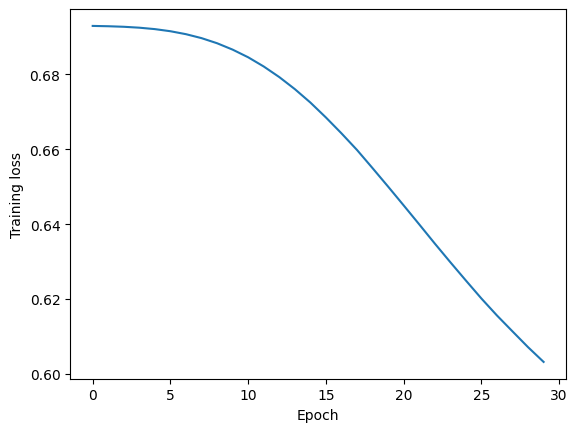

In [23]:
plt.plot([x[0] for x in all_train_losses], [x[1] for x in all_train_losses])
plt.xlabel("Epoch")
plt.ylabel("Training loss")

plt.show()

And also plot the validation recall@k over time:

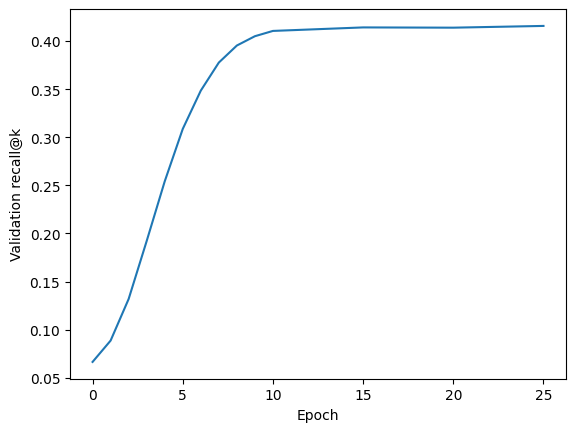

In [24]:
plt.plot([x[0] for x in all_val_recalls], [x[1] for x in all_val_recalls])
plt.xlabel("Epoch")
plt.ylabel("Validation recall@k")
plt.show()

# Visualize embeddings

Now let's visualize our learned multi-scale playlist/song embeddings!

We will make an animated video of the embeddings over the first 10 epochs (which is when the embeddings/loss are changing the most).

To visualize it, we will use Principal Components Analysis (PCA) to project each 64-dimensional vector down into 2-dimensions so we can visualize it in a plot.

#### Projecting down to 2 dimensions

In [25]:
pca_embs = []
for i in range(11): # just visualizing epochs 0-10
    embs = torch.load(os.path.join('embeddings/embeddings_epoch_' + str(i) + '.pt'), map_location=torch.device('cpu'))
    pca = PCA(n_components=2).fit_transform(embs)
    pca_embs.append(pca)

In [26]:
# Load playlist/song details
with open('playlist_info.json', 'r') as f:
  playlists = json.load(f)
  playlists = {int(k): v for k, v in playlists.items()}

with open('song_info.json', 'r') as f:
  songs = json.load(f)
  songs = {int(k): v for k, v in songs.items()}

# Visualizing country music playlists

During out inspection of the results, we noticed that there was a large cluster of playlists that stood out in particular. By manually inspecting those playlists, we noticed that they were primarily country music playlists.

To show this programatically, we will find all the playlists that have the word "country" in the title. This is not perfect, but it will serve as a good estimate of which playlists in the dataset are mainly country music.

In [27]:
# Find all playlists with "country" in the title
country = []
country_colors = [] # colors for plotting
for id in playlists:
    name = playlists[id]['name'].lower()
    if 'country' in name:
        country.append(country)
        country_colors.append(0)
    else:
        country_colors.append(1)

In [28]:
print(f"There are {len(country)} country playlists out of {len(playlists)} total playlists")

There are 736 country playlists out of 9296 total playlists


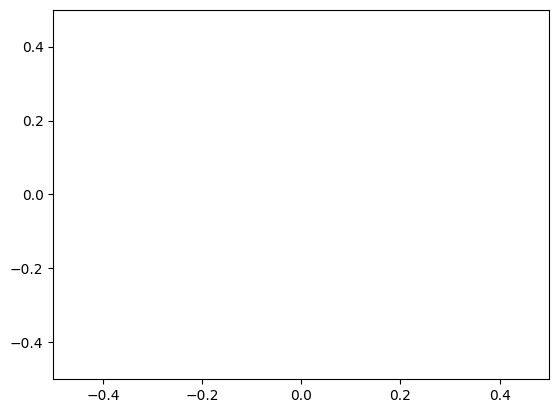

In [29]:
# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()

ax.set_xlim(( -0.5, 0.5))
ax.set_ylim((-0.5, 0.5))

colors = ['red', 'skyblue']
from matplotlib.colors import ListedColormap
cmap = ListedColormap(colors)


scat = ax.scatter([], [], c=[], s=3, alpha=0.3, cmap=cmap)

# NOTE: this plot below will be empty! Just ignore it and go to the next cell

In [30]:
def init():
    scat.set_offsets([])
    return scat,

In [31]:
def animate(i):
  embs = pca_embs[i]
  x, y = embs[:num_playlists, 0], embs[:num_playlists, 1] # only plotting playlists, not songs
  data = np.hstack((x[:,np.newaxis], y[:, np.newaxis]))
  scat.set_offsets(data)
  scat.set_array(country_colors)
  return (scat,)

In [32]:
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=11, interval=1000, blit=True)

Now let's watch the animated video as the embeddings change from epochs 0-10! The country playlists are in red, and non-country playlists are in blue.

In [33]:
HTML(anim.to_html5_video())

You can clearly see the separation as the country playlists diverge from the non-country playlists!

In [34]:
# f = "country_animation.gif"
# writergif = animation.PillowWriter(fps=1)
# anim.save(f, writer=writergif, dpi=160)

# Visualizing Drake songs

Now let's see the animated evolution of embeddings for all of Drake's songs that appear in the dataset.

We expect that they would slowly begin to cluster together over time.

In [35]:
drake_id = 'spotify:artist:3TVXtAsR1Inumwj472S9r4'
drake = []
drake_colors = [] # colors for plotting
drake_sizes = []  # sizes of the points when plotting
for id in songs:
    if songs[id]['artist_uri'] == drake_id:
      drake.append(id)
      drake_colors.append(0)
      drake_sizes.append(15)
    else:
      drake_colors.append(1)
      drake_sizes.append(3)

In [36]:
print(f"There are {len(drake)} Drake songs in the dataset")

There are 118 Drake songs in the dataset


In [37]:
colors = ['red', 'skyblue']
cmap_drake = ListedColormap(colors)

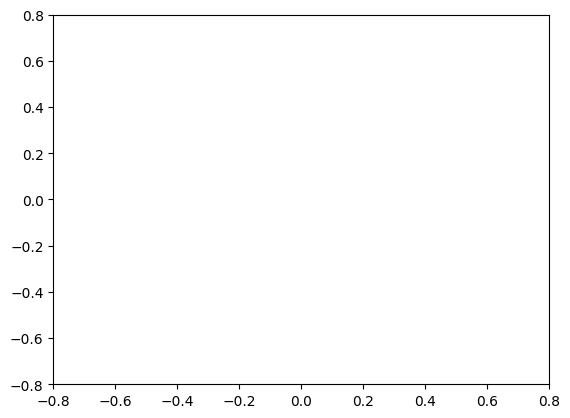

In [38]:
# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()

ax.set_xlim(( -0.8, 0.8))
ax.set_ylim((-0.8, 0.8))

scat = ax.scatter([], [], c=[], s=[], alpha=0.3, cmap=cmap_drake)

# NOTE: this plot will be empty! Just ignore it and continue to the next cell

In [39]:
def init():
    scat.set_offsets([])
    return scat,

In [40]:
def animate(i):
  embs = pca_embs[i]
  x, y = embs[num_playlists:, 0], embs[num_playlists:, 1] # only plotting songs, not playlists
  data = np.hstack((x[:,np.newaxis], y[:, np.newaxis]))
  scat.set_offsets(data)
  scat.set_array(drake_colors)
  scat.set_sizes(drake_sizes)
  return (scat,)

In [41]:
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=11, interval=1000, blit=True)

Below is the animation from epochs 0-10. We see that the red dots (Drake songs) begin to cluster together!

In [42]:
HTML(anim.to_html5_video())

In [ ]:
# f = "drake_animation.gif"
# writergif = animation.PillowWriter(fps=1)
# anim.save(f, writer=writergif, dpi=160)

# Visualizing Taylor Swift songs

Finally, let's see the songs of Taylor Swift.

Stay tuned to the end, since we make an interesting discovery!

In [43]:
swift_id = 'spotify:artist:06HL4z0CvFAxyc27GXpf02'
swift = []
swift_colors = []
swift_sizes = []
for id in songs:
    if songs[id]['artist_uri'] == swift_id:
      swift.append(id)
      swift_colors.append(0)
      swift_sizes.append(15)
    else:
      swift_colors.append(1)
      swift_sizes.append(3)

In [44]:
colors = ['red', 'skyblue']
cmap_swift = ListedColormap(colors)

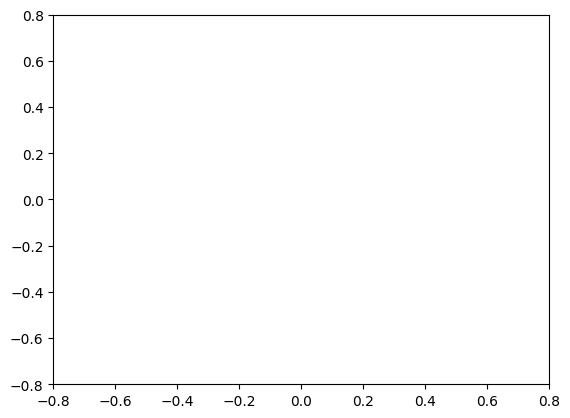

In [45]:
# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()

ax.set_xlim(( -0.8, 0.8))
ax.set_ylim((-0.8, 0.8))

scat = ax.scatter([], [], c=[], s=[], alpha=0.3, cmap=cmap_swift)

# NOTE: this plot will be empty! Just ignore it and continue to the next cell

In [46]:
def init():
    scat.set_offsets([])
    return scat,

In [47]:
def animate(i):
  embs = pca_embs[i]
  x, y = embs[num_playlists:, 0], embs[num_playlists:, 1] # only plotting songs, not playlists
  data = np.hstack((x[:,np.newaxis], y[:, np.newaxis]))
  scat.set_offsets(data)
  scat.set_array(swift_colors)
  scat.set_sizes(swift_sizes)
  return (scat,)

In [48]:
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=11, interval=1000, blit=True)

In [ ]:
HTML(anim.to_html5_video())

In [49]:
# f = "swift_animation.gif"
# writergif = animation.PillowWriter(fps=1)
# anim.save(f, writer=writergif, dpi=160)

You may notice something very interesting!

By the end of the GIF, Taylor Swift songs are right at the border between the country songs vs. non-country songs. This makes a lot of sense, since she started off as a country singer and later switched to pop music.

To explore this further, we will manually classify each of the 21 songs as being from her country vs. pop phases. We are mainly going off of the classifications of her songs on Wikipedia. You can see these below:

In [50]:
swift_pop = ['Look What You Made Me Do',
             'Shake It Off',
             'Style',
             "...Ready For It?",
             "Wildest Dreams",
             "I Knew You Were Trouble.",
             "22",
             "We Are Never Ever Getting Back Together",
             "Bad Blood",
             "Blank Space"]

swift_country = ['White Horse',
                 'Picture To Burn',
                 'Our Song',
                 'Everything Has Changed',
                 'You Belong With Me',
                 'Love Story',
                 'Red',
                 'Sparks Fly',
                 'Mean',
                 'Crazier',
                 'Safe & Sound - from The Hunger Games Soundtrack']

Now let's plot her country songs in blue, her pop songs in red, and all other songs in gray, using the embeddings from epoch 10.

In [51]:
swift_colors = []
swift_alphas = []
for id in songs:
    if songs[id]['artist_uri'] == swift_id:
      swift_alphas.append(1)
      if songs[id]['track_name'] in swift_pop:
        swift_colors.append("red")
      else: # then it's in swift_country
        swift_colors.append("blue")
    else:
      swift_colors.append("gray")
      swift_alphas.append(0.2)

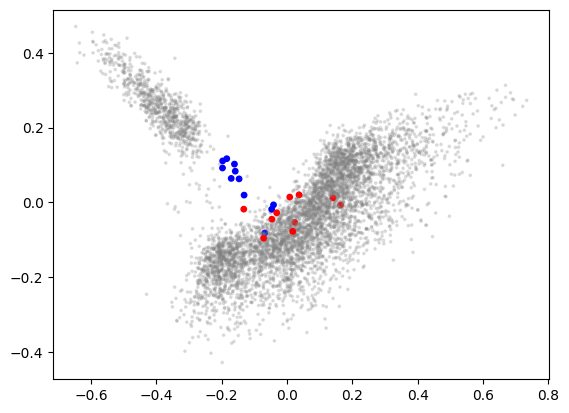

In [52]:
plt.scatter(pca_embs[10][num_playlists:,0], pca_embs[10][num_playlists:, 1], alpha=swift_alphas, color=swift_colors,
            s=swift_sizes)

It looks like we were correct! Her country songs (in blue) are much closer to the cluster of country songs, and her pop songs (red) are right in the middle of the non-country song area.

It even makes sense that her country songs are not entirely in the country cluster, because she has a lot of crossover appeal, which means she probably has many fans that listen to her country songs even if they don't listen to much country music in general. This crossover appeal likely pulls her country songs a bit back more in the direction of the non-country songs.

Anyway, this is an extremely interesting result. Our model appears to have learned to embed the different phases of Taylor Swift's career into two parts, completely by itself!